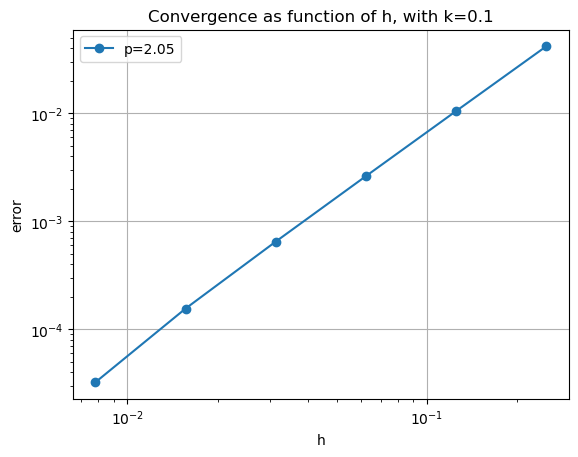

In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


def tridiag(v, d, w, N):
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

def f(x,a=1):
    #f(u) = au
    return a*x

def exact_sol(x, t):
    #exact solution for equation with bouandries constant zero and fixed mu.
    return np.sin(np.pi * x)*np.exp((-0.05*np.pi**2 + 1) * t)


def solver(N,k=0.001,mu=0.05,a=1,T_max = 1):
    #initializing discrete domain and related values
    x = np.linspace(0, 1, N+1)
    tgrid = [0]
    h = 1/N
    t_steps = int(T_max / k)
    r = mu*(k/(h**2))


    #matricies for crank-nicholson step
    A = tridiag(-r / 2, 1+r, -r / 2, N-1)
    B = tridiag(r/2, 1-r, r/2, N-1)

    #initial condition and array to store solution
    #adding initial condition to solution
    #U = np.ones(N+1) * np.sin(np.pi * x)
    #U[0] = 0
    #U[-1] = 0
    #U_inner = U[1:-1]
    #U_sol = []
    #U_sol.append(U)
    
    U = np.ones(N+1) * np.sin(np.pi * x)
    U_inner = U[1:-1]
    U_sol = np.zeros((N+1,t_steps+1))
    U_sol[:,0] = U

    #loop iterating over timesteps
    for t in range(1,t_steps+1):
        #updating time grid
        tgrid.append(t*k)

        #take into account for U values that get lost when excluding boundary
        #commented out due to boundary value being constant 0 on both sides 
        #U_inner[0] = U_inner[0] + (r/2)
        #U_inner[-1] = U_inner[-1] + (r/2)

        #calculating rhs from known values of cranck-nicholson scheme
        b = np.dot(B, U_inner) + k * f(U_inner)

        #take into account boundary as its outside the system
        #commented out due to boundary value being constant 0 on both sides
        #b[0] = b[0] + (r/2)
        #b[-1] = b[-1] + (r/2)

        #solve AU_star = b
        U_star_inner = np.linalg.solve(A, b)
        #explicit step
        U_new_inner = U_star_inner + (k / 2) * (f(U_star_inner) - f(U_inner))

        #updating solution
        U[1:-1] = U_new_inner
        U_inner = U[1:-1]

        U_sol[:,t] = U
    return np.array(U_sol), x, np.array(tgrid)


def main1():
    #main function for testing solver
    kvals=[0.1,0.01,0.001,0.0001]
    for k in kvals:
        u,x,t = solver(25,k,a=1)
    X,T = np.meshgrid(x,t)
    uexac = exact_sol(X,T).T
    #print(u[10])
    #print(uexac[10])

    Eh = uexac-u
    print(np.max(np.abs(Eh)))
    #print(uexac[-1]-u[-1])

    return 0
 
def convergence_space(u_exact, solver=solver): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 4
    for p in range(P):
        U, x, t = solver(M,k=0.01,mu=0.05,a=1)
        X, T = np.meshgrid(x,t)
        ue = u_exact(X,T).T
        Eh = ue[:,-1]-U[:,-1]
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        #print(1/M)
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

H, E, p = convergence_space(exact_sol)
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate}) 
df

plt.title("Convergence as function of h, with k=0.1");
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();




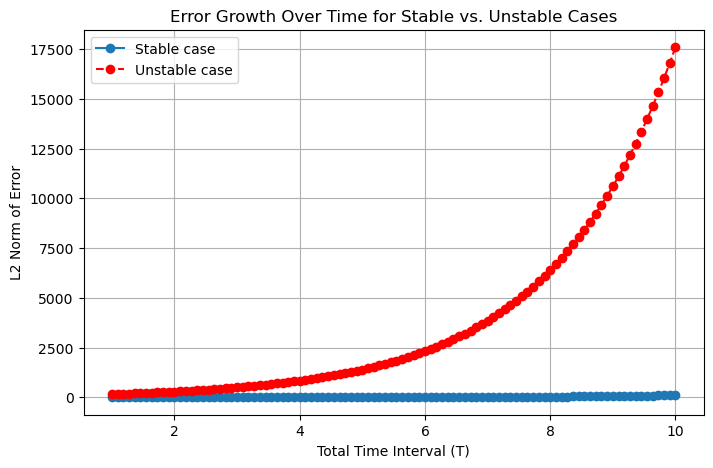

In [ ]:
def plot_stability():
    N = 25
    k = 0.001  
    h = 1 / N
    mu = 0.05  

    T_values = np.linspace(1, 10, 100) 
    errors_stable = []
    errors_unstable = []

    for T_max in T_values:
        t_steps = int(T_max / k)

        #stable case
        U_stable, x, t = solver(N, k, mu, a=1, T_max=T_max)
        U_stable = U_stable[:, :t_steps+1] 

        #unstable case
        U_unstable, _, _ = solver(N, k, mu * 200, a=1, T_max=T_max) 
        U_unstable = U_unstable[:, :t_steps+1]

        #compute exact solution 
        X, T = np.meshgrid(x, t[:t_steps+1], indexing="ij")
        U_exact = exact_sol(X, T)


        #compute L2 norm of the error
        error_stable = np.linalg.norm(U_exact - U_stable, ord=2)
        error_unstable = np.linalg.norm(U_exact - U_unstable, ord=2)

        errors_stable.append(error_stable)
        errors_unstable.append(error_unstable)

    #plots
    plt.figure(figsize=(8, 5))
    plt.plot(T_values, errors_stable, label="Stable case", marker="o", linestyle="-")
    plt.plot(T_values, errors_unstable, label="Unstable case", marker="o", linestyle="--", color="red")
    plt.xlabel("Total Time Interval (T)")
    plt.ylabel("L2 Norm of Error")
    plt.title("Error Growth Over Time for Stable vs. Unstable Cases")
    plt.legend()
    plt.grid()
    plt.show()

plot_stability()


In [ ]:
def fini(x):
    #function for initial condition for 1 dimensional case where some are infected close to the middel of the domain
    return (np.heaviside(x-0.40,1)-np.heaviside(x-0.60,1))*(-0.5*np.sin(((np.pi*5))*(x-0.2)))

def plot_solution(x, t, U, txt='Solution'):
    #help funtion for plotting from code uploaded previous year of course(heat_forweuler_2024.ipynb)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    #ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

def fs(s,i,beta, gamma):
    #reaction term for S
    return -beta*i*s

def fi(s,i,beta,gamma):
    #reaction term for I
    return beta*i*s-gamma*i

def solver2(N,k=0.001,T_max = 1, beta =3, gamma = 1, mus=0.05, mui = 0.05):
    #solver for simulating given SIR model modified to PDE system in one space dimension
    #initializing discrete domain and related values
    x = np.linspace(0, 1, N+1)
    tgrid = [0]
    h = 1/N
    t_steps = int(T_max / k)
    rs = mus*(k/(h**2))
    ri = mui*(k/(h**2))

    #matricies for crank-nicholson step
    As = tridiag(-rs / 2, 1+rs, -rs / 2, N-1)
    Bs = tridiag(rs/2, 1-rs, rs/2, N-1)

    Ai = tridiag(-ri / 2, 1+ri, -ri / 2, N-1)
    Bi = tridiag(ri/2, 1-ri, ri/2, N-1)


    #initial condition and array to store solution
    #adding initial condition to solution
    Us = np.ones(N+1)
    for i in range(len(x)):
        Us[i] = Us[i]-fini(x[i])
    Us_inner = Us[1:-1]
    Us_sol = np.zeros((N+1,t_steps+1))
    Us_sol[:,0] = Us

    Ui = np.zeros(N+1)
    for i in range(len(x)):
        Ui[i] = fini(x[i])
    Ui_inner = Ui[1:-1]
    Ui_sol = np.zeros((N+1,t_steps+1))
    Ui_sol[:,0] = Ui


    #loop iterating over timesteps
    for t in range(1,t_steps+1):
        #updating time grid
        tgrid.append(t*k)

        #take into account for U values that get lost when looking at N-1 system
        Us_inner[0] = Us_inner[0] + (rs/2)
        Us_inner[-1] = Us_inner[-1] + (rs/2)

        #calculating rhs from known values of cranck-nicholson scheme
        bs = np.dot(Bs, Us_inner) + k * fs(Us_inner, Ui_inner, beta, gamma)
        
        #take into account for U values that get lost when looking at N-1 system
        #commented out due to boundary being zero
        #Ui_inner[0] = Ui_inner[0] + (ri/2)
        #Ui_inner[-1] = Ui_inner[-1] + (ri/2)

        #calculating rhs from known values of cranck-nicholson scheme
        bi = np.dot(Bi, Ui_inner) + k * fi(Us_inner, Ui_inner, beta, gamma)

        #take into account boundary as its outside the system for S
        bs[0] = bs[0] + (rs/2)
        bs[-1] = bs[-1] + (rs/2)

        #commented out due to boundary value being constant 0 on both sides of x for I
        #bi[0] = bi[0] + (ri/2)
        #bi[-1] = bi[-1] + (ri/2)

        #solve AU_star = b
        Us_star_inner = np.linalg.solve(As, bs)
        Ui_star_inner = np.linalg.solve(Ai, bi)

        #explicit step
        Us_new_inner = Us_star_inner + (k / 2) * (fs(Us_star_inner, Ui_star_inner,beta, gamma) - fs(Us_inner, Ui_inner, beta, gamma))
        Ui_new_inner = Ui_star_inner + (k / 2) * (fi(Us_star_inner, Ui_star_inner,beta, gamma) - fi(Us_inner, Ui_inner, beta, gamma))

        #updating solution S
        Us[1:-1] = Us_new_inner
        Us_inner = Us[1:-1]

        Us_sol[:,t] = Us
        ###################################################################################################################################
        #updating solution I
        Ui[1:-1] = Ui_new_inner
        Ui_inner = Ui[1:-1]

        Ui_sol[:,t] = Ui

    return np.array(Us_sol),np.array(Ui_sol), x, np.array(tgrid)
    

def main2():
    #main function for simulating model
    us,ui,x,t = solver2(24,k=0.0001,T_max=7, beta = 3,gamma=1,mus=0.05, mui = 0.05)
    plt.figure(figsize=(8, 5))
    plot_solution(x, t, us, txt='Solution')
    plt.title("Distribution of susceptible people");
    plot_solution(x, t, ui, txt='Solution')
    plt.title("Distribution of infected people");
    #plt.legend()
    plt.show()
    return 0

0.0010753284600895086


<Figure size 800x500 with 0 Axes>

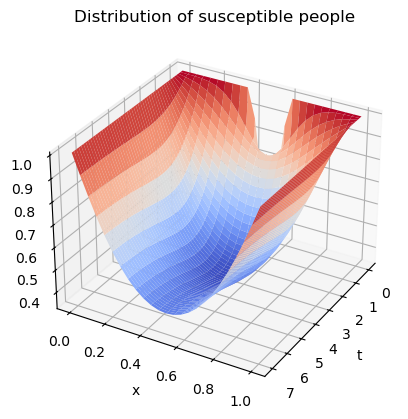

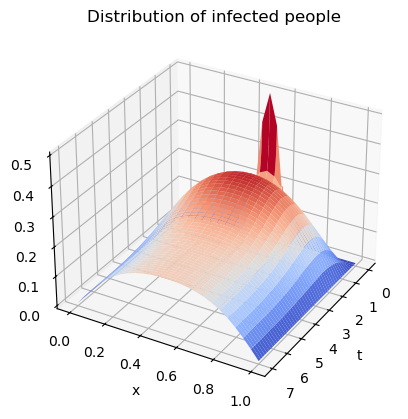

0

In [ ]:
main1()
main2()